In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [2]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [4]:
def plot_time_series(x, y, xlabel="Date", ylabel="Value", figsize=(14, 4), 
                     use_weekday_locator=False, use_year_locator=True, title=None, 
                     add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_weekday_locator:
    formatter = mdates.DateFormatter("%d-%b")
    locator = mdates.DayLocator(interval=14)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

In [5]:
def plot_time_series_data_window(
  x, y, xlabel="Date", ylabel="Value", figsize=(14, 4), 
  use_weekday_locator=False, use_year_locator=True, title=None, 
  add_mark_at=None, input_width=24, label_width=24):

  fig, ax = plt.subplots(figsize=figsize)

  num_of_rows = len(x)
  data_window_size = input_width + label_width
  num_of_data_window = num_of_rows // data_window_size
  input_color = "tab:blue" 
  label_color = "tab:orange" 
  
  for i in range(num_of_data_window):
    start_width_idx = i*data_window_size
    end_width_idx = i*data_window_size + input_width
    ax.plot(x.iloc[start_width_idx:end_width_idx], 
            y.iloc[start_width_idx:end_width_idx], color=input_color, 
            marker="s")
    
    start_label_idx = i*data_window_size + input_width
    end_label_idx = i*data_window_size + input_width + label_width
    ax.plot(x.iloc[start_label_idx:end_label_idx], 
            y.iloc[start_label_idx:end_label_idx], color=label_color, 
            marker="x")
        
  if use_weekday_locator:
    formatter = mdates.DateFormatter("%d-%b")
    locator = mdates.DayLocator(interval=14)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

### Load

In [6]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [7]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [8]:
df_cdb_with_tipe = df_cdb_with_initial.copy()
def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_individu = df_cdb_with_tipe[df_cdb_with_tipe["Tipe Pembeli"] == "INDIVIDU"].copy()
df_cdb_individu

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


In [9]:
df_E = df_cdb_individu[df_cdb_individu["initial Varian Plus"] == "E"].copy()
df_E

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
5,2021-01-04,DEVRYNALDO RIZAL,JL JEND A YANI,KARANG JATI,BALIKPAPAN TENGAH,LAKI-LAKI,1978-12-18,Pegawai Swasta-Jasa,"> Rp. 6.000.000,-",SARJANA,ES5,E,INDIVIDU,46
14,2021-01-06,MULYADI,JL SYARIFUDIN YOES,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1974-12-23,Wiraswasta-Konstruksi,"> Rp. 6.000.000,-",SLTA/SMU,ES4,E,INDIVIDU,50
15,2021-01-06,MUHAMMAD FADILLAH,JL AL MAKMUR III,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1997-12-07,MAHASISWA/PELAJAR,"< Rp. 900.000,-",SLTP/SMP,ES4,E,INDIVIDU,27
18,2021-01-06,ANDI WIJAYANTO,JL SUGENG RAWUH II,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1995-07-06,Wiraswasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ES5,E,INDIVIDU,29
23,2021-01-07,PURWANTO,PT WKP AFD BRAVO,WARU,WARU,LAKI-LAKI,1995-01-07,Pegawai Swasta-Pertanian,"< Rp. 900.000,-",SLTA/SMU,EXF,E,INDIVIDU,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6294,2024-05-31,KRISHANDY DHANYSA PRATAMA,JL. MT HARYONO,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,2005-07-03,Wiraswasta-Perdagangan,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,ESF,E,INDIVIDU,19
6319,2024-06-05,FIRMANSYAH K,JL. SEMOI,MARGA SARI,BALIKPAPAN BARAT,LAKI-LAKI,1994-01-25,MAHASISWA/PELAJAR,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ES6,E,INDIVIDU,31
6459,2024-06-30,PT KEMILAU INDAH NUSANTARA,JL. POROS SANGATTA-BENGALON KM. 32,MUARA BENGALON,BENGALON,LAKI-LAKI,1985-06-30,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,EG2,E,INDIVIDU,39
6841,2024-08-31,LINUS HARIMIN,JL BATU RATNA KM 11,KARANG JOANG,BALIKPAPAN UTARA,LAKI-LAKI,1973-09-23,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ESF,E,INDIVIDU,51


In [10]:
df_E_count = df_E[["Tgl. Mohon"]].copy()
df_E_count["count"] = 1.
df_E_count = df_E_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_E_count["cumulative_sum"] = df_E_count["count"].cumsum()
df_E_count

,Tgl. Mohon,count,cumulative_sum
0,2021-01-04,1,1
1,2021-01-06,3,4
2,2021-01-07,1,5
3,2021-01-14,1,6
4,2021-01-21,1,7
...,...,...,...
135,2024-05-10,1,163
136,2024-05-31,1,164
137,2024-06-05,1,165
138,2024-06-30,1,166


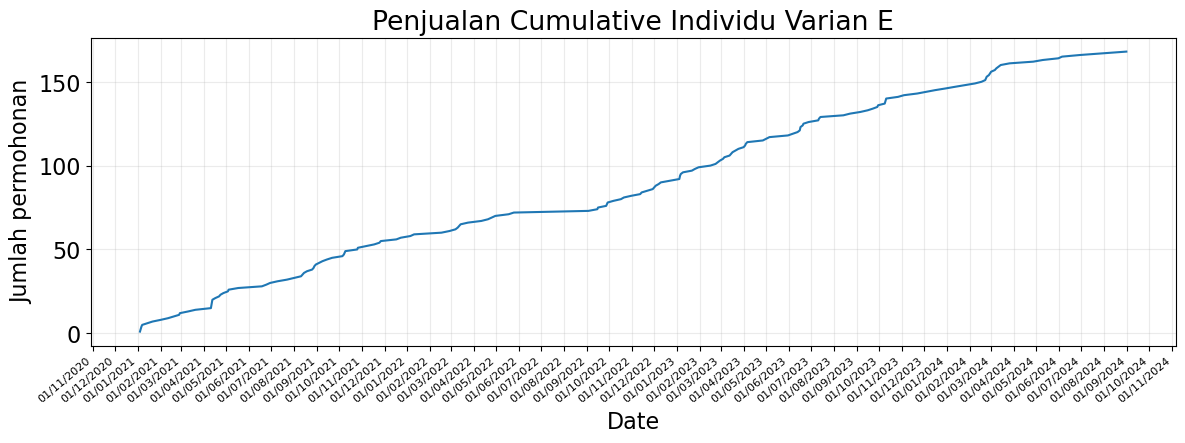

In [11]:
plot_time_series(df_E_count["Tgl. Mohon"], df_E_count["cumulative_sum"], use_year_locator=True, 
                  ylabel="Jumlah permohonan", title="Penjualan Cumulative Individu Varian E")

## Feature engineering

In [12]:
df_E_count.describe()

,Tgl. Mohon,count,cumulative_sum
count,140,140.000000,140.000000
mean,2022-09-17 20:03:25.714285824,1.200000,85.585714
min,2021-01-04 00:00:00,1.000000,1.000000
25%,2021-10-01 12:00:00,1.000000,45.750000
50%,2022-11-13 00:00:00,1.000000,83.500000
75%,2023-07-11 06:00:00,1.000000,127.250000
max,2024-08-31 00:00:00,5.000000,168.000000
std,NaN,0.525603,47.691452


- Berdasarkan `count` penjualan terjadi paling sedikit 1 unit, paling banyak 5 unit, dan mayoritas 1 unit terjual artinya sebagian besar penjualan berlangsung dalam jumlah kecil.
- Kolom `cumulative_sum` tidak cocok untuk digunakan langsung dalam prediksi karena secara definisi selalu meningkat namun bisa digunakan untuk membuat fitur baru seperti jumlah permohonan dalam periode tertentu (sliding window) atau perubahan kumulatif

yang dilakukan
1. Mengurutkan data berdasarkan tanggal permohonan untuk rolling window
2. Karena penjualan per hari mayoritas 1 unit, maka menambah fitur baru:
    - `rolling_7days` yaitu jumlah permohonan dalam 7 hari terakhir untuk melihat tren mingguan
    - `delta_count` untuk melihat selisih jumlah permohonan di hari sebelumnya
3. Encoding fitur waktu dengan menambah fitur baru
    - `month_sin` dan `month_cos` untuk merepresentasikan nilai bulan Jan = 1 sampai Des = 12 secara periodik (siklikal), misalnya untuk menangani bulan Des (12) ke Jan (1) berdekatan dalam waktu, namun secara numerik 12 dan 1 terlihat jauh karena model tidak mengerti bahwa bulan itu berulang
    - `weekday_sin` dan `weekday_cos` untuk merepresentasikan hari dalam mingguan Senin = 0, Minggu = 6 secara siklikal
sehingga dengan sinus dan cosinus dapat membuat cyclical encoding (lingkaran) agar model bisa menangkap pola berulang karena berada pada sudut yang mirip di lingkaran. 

### Add Fitur

In [13]:
df_E_rolling = df_E_count.copy()
df_E_rolling = df_E_count.sort_values("Tgl. Mohon").reset_index(drop=True)

df_E_rolling["delta_count"] = df_E_rolling["count"].diff().fillna(0)
df_E_rolling["rolling_7days"] = df_E_rolling["count"].rolling(window=7, 
                                min_periods=1).sum()

df_E_rolling['month'] = df_E_rolling['Tgl. Mohon'].dt.month
df_E_rolling['weekday'] = df_E_rolling['Tgl. Mohon'].dt.weekday
df_E_rolling
df_E_rolling

,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days,month,weekday
0,2021-01-04,1,1,0.0,1.0,1,0
1,2021-01-06,3,4,2.0,4.0,1,2
2,2021-01-07,1,5,-2.0,5.0,1,3
3,2021-01-14,1,6,0.0,6.0,1,3
4,2021-01-21,1,7,0.0,7.0,1,3
...,...,...,...,...,...,...,...
135,2024-05-10,1,163,0.0,9.0,5,4
136,2024-05-31,1,164,0.0,8.0,5,4
137,2024-06-05,1,165,0.0,8.0,6,2
138,2024-06-30,1,166,0.0,8.0,6,6


### Encoding Fitur Waktu

In [14]:
df_E_rolling['month_sin'] = np.sin(2 * np.pi * df_E_rolling['month'] / 12)
df_E_rolling['month_cos'] = np.cos(2 * np.pi * df_E_rolling['month'] / 12)

df_E_rolling['weekday_sin'] = np.sin(2 * np.pi * df_E_rolling['weekday'] / 7)
df_E_rolling['weekday_cos'] = np.cos(2 * np.pi * df_E_rolling['weekday'] / 7)
df_E_rolling

,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-04,1,1,0.0,1.0,1,0,5.000000e-01,0.866025,0.000000,1.000000
1,2021-01-06,3,4,2.0,4.0,1,2,5.000000e-01,0.866025,0.974928,-0.222521
2,2021-01-07,1,5,-2.0,5.0,1,3,5.000000e-01,0.866025,0.433884,-0.900969
3,2021-01-14,1,6,0.0,6.0,1,3,5.000000e-01,0.866025,0.433884,-0.900969
4,2021-01-21,1,7,0.0,7.0,1,3,5.000000e-01,0.866025,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...
135,2024-05-10,1,163,0.0,9.0,5,4,5.000000e-01,-0.866025,-0.433884,-0.900969
136,2024-05-31,1,164,0.0,8.0,5,4,5.000000e-01,-0.866025,-0.433884,-0.900969
137,2024-06-05,1,165,0.0,8.0,6,2,1.224647e-16,-1.000000,0.974928,-0.222521
138,2024-06-30,1,166,0.0,8.0,6,6,1.224647e-16,-1.000000,-0.781831,0.623490


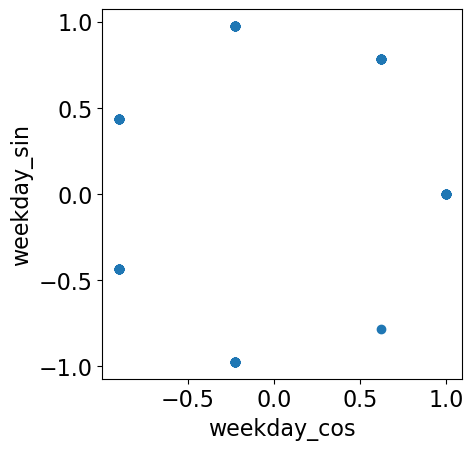

In [15]:
n_sample = 100   # randomly sample from the df_E_rolling

fig, ax = plt.subplots()

sampled_data = df_E_rolling.sample(n_sample)
ax.plot(sampled_data["weekday_cos"], sampled_data["weekday_sin"], linestyle="none",
        marker="o")

ax.set_aspect("equal")
ax.set_xlabel("weekday_cos")
ax.set_ylabel("weekday_sin")
plt.show(fig)

In [16]:
df_E_rolling.describe()

,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
count,140,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,1.400000e+02,140.000000,140.000000
mean,2022-09-17 20:03:25.714285824,1.200000,85.585714,0.007143,8.207143,5.885714,2.685714,0.110201,4.853020e-02,0.078335,-0.119129
min,2021-01-04 00:00:00,1.000000,1.000000,-4.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000e+00,-0.974928,-0.900969
25%,2021-10-01 12:00:00,1.000000,45.750000,0.000000,7.000000,3.000000,1.000000,-0.866025,-5.000000e-01,-0.433884,-0.900969
50%,2022-11-13 00:00:00,1.000000,83.500000,0.000000,8.000000,5.000000,3.000000,0.500000,6.123234e-17,0.000000,-0.222521
75%,2023-07-11 06:00:00,1.000000,127.250000,0.000000,9.000000,9.000000,4.000000,0.866025,5.000000e-01,0.781831,0.623490
max,2024-08-31 00:00:00,5.000000,168.000000,4.000000,12.000000,12.000000,6.000000,1.000000,1.000000e+00,0.974928,1.000000
std,NaN,0.525603,47.691452,0.763336,1.349108,3.519904,1.767353,0.746935,6.593013e-01,0.723894,0.680218


In [17]:
# Menghitung korelasi antar kolom numerik
corr_matrix = df_E_rolling.corr()
print(corr_matrix)


                Tgl. Mohon     count  cumulative_sum  delta_count  \
Tgl. Mohon        1.000000 -0.044063        0.995516     0.013225   
count            -0.044063  1.000000       -0.042017     0.731596   
cumulative_sum    0.995516 -0.042017        1.000000     0.010358   
delta_count       0.013225  0.731596        0.010358     1.000000   
rolling_7days     0.064268  0.225234        0.091801     0.005539   
month             0.069062 -0.080883        0.069186    -0.005049   
weekday           0.186113 -0.009294        0.179394    -0.083647   
month_sin         0.003244  0.057658        0.009401    -0.014008   
month_cos        -0.011725 -0.000596       -0.037256     0.009771   
weekday_sin      -0.145786  0.017659       -0.135733     0.044448   
weekday_cos      -0.074411  0.026329       -0.070707     0.117506   

                rolling_7days     month   weekday  month_sin  month_cos  \
Tgl. Mohon           0.064268  0.069062  0.186113   0.003244  -0.011725   
count                

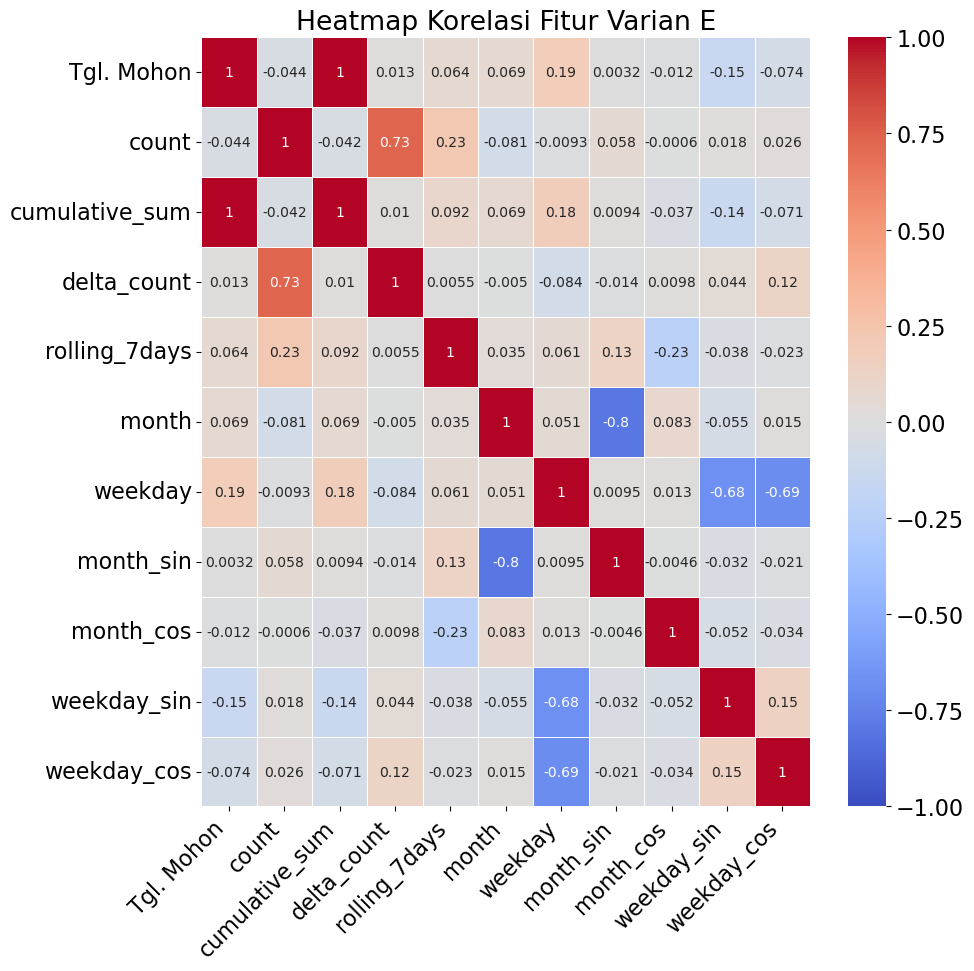

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5,
    vmin=-1, vmax=1, annot_kws={"size": 10})
plt.title("Heatmap Korelasi Fitur Varian E")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


Keterangan:
- 1 = korelasi positif sempurna → dua kolom bergerak bersama (jika satu naik, yang lain juga naik).
- -1 = korelasi negatif sempurna → dua kolom bergerak berlawanan.
- 0 = tidak ada hubungan linear antara dua kolom.
- Merah = korelasi positif.
- Biru = korelasi negatif.
- Abu-abu = mendekati nol (tidak terlalu berkorelasi).

Insight:
- `count` dan `delta_count` memiliki korelasi positif yaitu 0.73
- `rolling_7days` memiliki korelasi yang rendah terhadap variabel lain

In [19]:
# Menampilkan korelasi dengan 'count'
corr_matrix = df_E_rolling.corr()
print(corr_matrix['count'].sort_values(ascending=False))


count             1.000000
delta_count       0.731596
rolling_7days     0.225234
month_sin         0.057658
weekday_cos       0.026329
weekday_sin       0.017659
month_cos        -0.000596
weekday          -0.009294
cumulative_sum   -0.042017
Tgl. Mohon       -0.044063
month            -0.080883
Name: count, dtype: float64


### Data Splitting

In [19]:
n_data = len(df_E_rolling)

# Split 70:20:10 (train:validation:test)
idx_train = int(n_data * 0.7)
idx_test = int(n_data * 0.9)

train_df = df_E_rolling[:idx_train].copy()
val_df = df_E_rolling[idx_train:idx_test].copy()
test_df = df_E_rolling[idx_test:].copy()

print(f"len(train, val, test): {len(train_df), len(val_df), len(test_df)}")

len(train, val, test): (98, 28, 14)


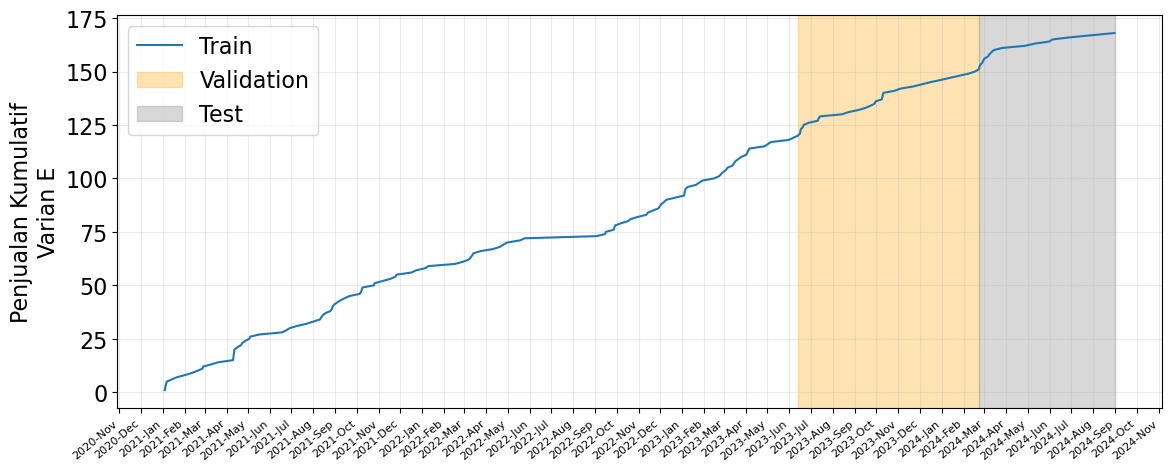

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_E_rolling['Tgl. Mohon'], df_E_rolling["cumulative_sum"], label="Train", color="tab:blue")

# add forecast area
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
           color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df['Tgl. Mohon'].iloc[0], test_df['Tgl. Mohon'].iloc[-1], 
           color="gray", alpha=0.3, label="Test")

ax.grid("on")
ax.set_ylabel("Penjualan Kumulatif\nVarian E")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_fontsize(8)
    label.set_horizontalalignment('right')

ax.legend()

plt.tight_layout()
plt.show()

In [21]:
train_df

,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-04,1,1,0.0,1.0,1,0,0.500000,0.866025,0.000000,1.000000
1,2021-01-06,3,4,2.0,4.0,1,2,0.500000,0.866025,0.974928,-0.222521
2,2021-01-07,1,5,-2.0,5.0,1,3,0.500000,0.866025,0.433884,-0.900969
3,2021-01-14,1,6,0.0,6.0,1,3,0.500000,0.866025,0.433884,-0.900969
4,2021-01-21,1,7,0.0,7.0,1,3,0.500000,0.866025,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...
93,2023-04-04,1,113,0.0,9.0,4,1,0.866025,-0.500000,0.781831,0.623490
94,2023-04-06,1,114,0.0,9.0,4,3,0.866025,-0.500000,0.433884,-0.900969
95,2023-04-27,1,115,0.0,9.0,4,3,0.866025,-0.500000,0.433884,-0.900969
96,2023-05-06,2,117,1.0,9.0,5,5,0.500000,-0.866025,-0.974928,-0.222521


scaling data

In [22]:
column_for_scaling = ["count", "cumulative_sum", "rolling_7days", "delta_count", 
                      "month", "weekday", "month_sin", "month_cos", "weekday_sin", "weekday_cos"]

# Define a scaler object
scaler_obj = MinMaxScaler()
scaler_obj.fit(train_df[column_for_scaling])

# Scaling train, val, test
train_scale_df_e = train_df.copy()
val_scale_df_e = val_df.copy()
test_scale_df_e = test_df.copy()

train_scale_df_e[column_for_scaling] = scaler_obj.transform(train_scale_df_e[column_for_scaling])
val_scale_df_e[column_for_scaling] = scaler_obj.transform(val_scale_df_e[column_for_scaling])
test_scale_df_e[column_for_scaling] = scaler_obj.transform(test_scale_df_e[column_for_scaling])

display(train_scale_df_e.head())
display(val_scale_df_e.head())
display(test_scale_df_e.head())

,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-04,0.0,0.000000,0.50,0.000000,0.0,0.000000,0.75,0.933013,0.500000,1.000000e+00
1,2021-01-06,0.5,0.025641,0.75,0.272727,0.0,0.333333,0.75,0.933013,1.000000,3.568959e-01
2,2021-01-07,0.0,0.034188,0.25,0.363636,0.0,0.500000,0.75,0.933013,0.722521,5.551115e-17
3,2021-01-14,0.0,0.042735,0.50,0.454545,0.0,0.500000,0.75,0.933013,0.722521,5.551115e-17
4,2021-01-21,0.0,0.051282,0.50,0.545455,0.0,0.500000,0.75,0.933013,0.722521,5.551115e-17


,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
98,2023-06-13,0.25,1.017094,0.625,0.727273,0.454545,0.166667,0.5,0.0,0.900969,0.801938
99,2023-06-16,0.00,1.025641,0.375,0.727273,0.454545,0.666667,0.5,0.0,0.277479,0.000000
100,2023-06-17,0.25,1.042735,0.625,0.818182,0.454545,0.833333,0.5,0.0,0.000000,0.356896
101,2023-06-20,0.00,1.051282,0.375,0.818182,0.454545,0.166667,0.5,0.0,0.900969,0.801938
102,2023-06-21,0.00,1.059829,0.500,0.818182,0.454545,0.333333,0.5,0.0,1.000000,0.356896


,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
126,2024-02-23,0.00,1.290598,0.500,0.636364,0.090909,0.666667,0.933013,0.75,0.277479,0.000000
127,2024-02-24,0.00,1.299145,0.500,0.636364,0.090909,0.833333,0.933013,0.75,0.000000,0.356896
128,2024-02-27,0.00,1.307692,0.500,0.636364,0.090909,0.166667,0.933013,0.75,0.900969,0.801938
129,2024-03-01,0.25,1.324786,0.625,0.727273,0.181818,0.666667,1.000000,0.50,0.277479,0.000000
130,2024-03-06,0.00,1.333333,0.375,0.636364,0.181818,0.333333,1.000000,0.50,1.000000,0.356896


In [23]:
train_scale_df_e.to_csv("./data/train_scale_e.csv", index=False)
val_scale_df_e.to_csv("./data/val_scale_e.csv", index=False)
test_scale_df_e.to_csv("./data/test_scale_e.csv", index=False)

In [24]:
dataset_section = ['train', 'val', 'test']
dataset = {}
for section in dataset_section:
  dataset[f"{section}_scale_df_e"] = pd.read_csv(f"./data/{section}_scale_e.csv",
                                                parse_dates=["Tgl. Mohon"])
dataset["train_scale_df_e"]

,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-04,0.00,0.000000,0.500,0.000000,0.000000,0.000000,0.750000,0.933013,0.500000,1.000000e+00
1,2021-01-06,0.50,0.025641,0.750,0.272727,0.000000,0.333333,0.750000,0.933013,1.000000,3.568959e-01
2,2021-01-07,0.00,0.034188,0.250,0.363636,0.000000,0.500000,0.750000,0.933013,0.722521,5.551115e-17
3,2021-01-14,0.00,0.042735,0.500,0.454545,0.000000,0.500000,0.750000,0.933013,0.722521,5.551115e-17
4,2021-01-21,0.00,0.051282,0.500,0.545455,0.000000,0.500000,0.750000,0.933013,0.722521,5.551115e-17
...,...,...,...,...,...,...,...,...,...,...,...
93,2023-04-04,0.00,0.957265,0.500,0.727273,0.272727,0.166667,0.933013,0.250000,0.900969,8.019377e-01
94,2023-04-06,0.00,0.965812,0.500,0.727273,0.272727,0.500000,0.933013,0.250000,0.722521,5.551115e-17
95,2023-04-27,0.00,0.974359,0.500,0.727273,0.272727,0.500000,0.933013,0.250000,0.722521,5.551115e-17
96,2023-05-06,0.25,0.991453,0.625,0.727273,0.363636,0.833333,0.750000,0.066987,0.000000,3.568959e-01


#### Fluktuasi nilai `rolling_7days`

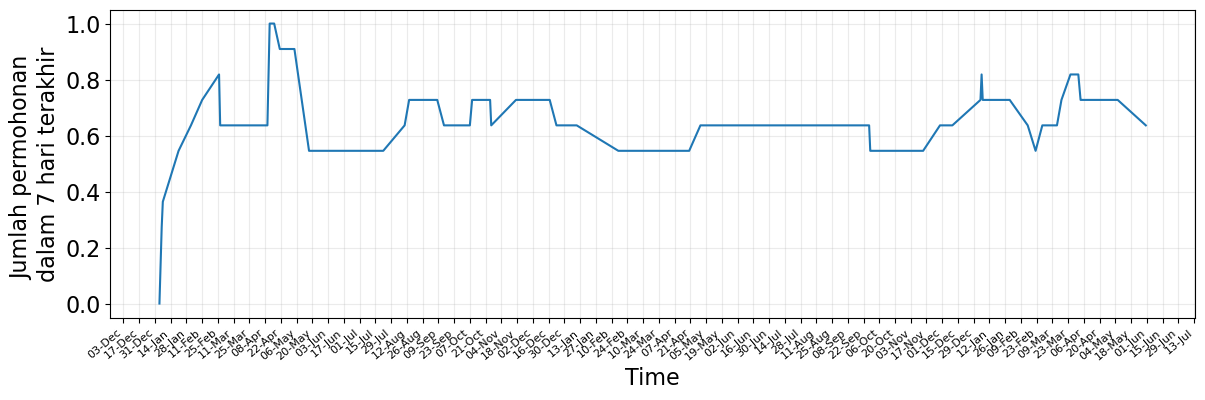

In [25]:
num_of_rows = 100
train_scale_df_e_selected = dataset["train_scale_df_e"]
plot_time_series(train_scale_df_e_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_e_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir",
                  use_weekday_locator=True, use_year_locator=False)

#### Data Windowing

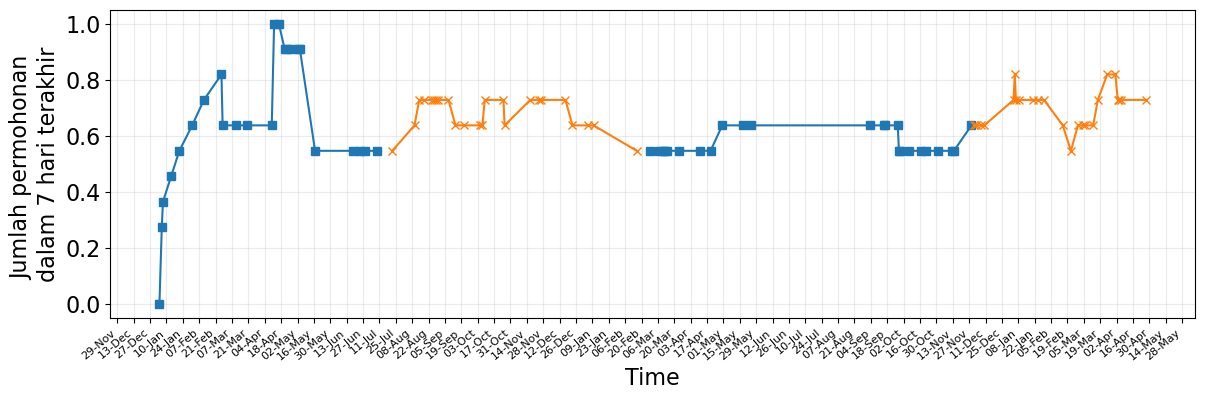

In [26]:
num_of_rows = 100
train_scale_df_e_selected = dataset["train_scale_df_e"]
plot_time_series_data_window(train_scale_df_e_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_e_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir",
                  use_weekday_locator=True, use_year_locator=False)

## Model Development

In [27]:
def create_multivariate_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(sequence_length, len(X)):
        Xs.append(X[i-sequence_length:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

In [28]:
input_columns = [col for col in column_for_scaling if col != "rolling_7days"]
input_columns_autoreg = input_columns + ["rolling_7days"]

feature_col = "rolling_7days"

train_X = train_scale_df_e[input_columns].values
val_X = val_scale_df_e[input_columns].values
test_X = test_scale_df_e[input_columns].values

train_y = train_scale_df_e[feature_col].values
val_y = val_scale_df_e[feature_col].values
test_y = test_scale_df_e[feature_col].values

sequence_length = 10
X_train, y_train = create_multivariate_sequences(train_X, train_y, sequence_length)
X_val, y_val = create_multivariate_sequences(val_X, val_y, sequence_length)

In [29]:
# --- Model LSTM ---
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

c:\ProgramData\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,609 (170.35 KB)

 Trainable params: 43,609 (170.35 KB)

 Non-trainable params: 0 (0.00 B)

### Data Training

epoch = 50

In [30]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 683ms/step - loss: 0.5147 - val_loss: 0.2513 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2210 - val_loss: 0.0744 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0683 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0692 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0732 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0419 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0417 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0447 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0419 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━

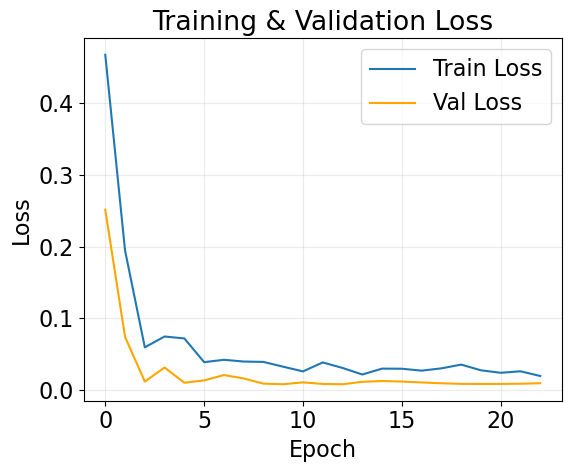

In [31]:
# Visualisasi
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid("on")
plt.tight_layout()
plt.show()

### Prediksi `rolling 7 days`

In [32]:
# --- Fungsi Prediksi Autoregressive ---
# Ambil kolom yang digunakan sebagai input ke model
input_columns = [col for col in column_for_scaling if col != "rolling_7days"]

# Ambil sequence terakhir dari validation sebagai seed
last_sequence = val_scale_df_e[input_columns + ["rolling_7days"]].values[-sequence_length:].copy()

# Placeholder untuk menyimpan hasil prediksi (dalam skala yang sudah di-scale)
scaled_preds = []

# Autoregressive loop
for i in range(len(test_df)):
    # Pisahkan input features dan target dari last_sequence
    X_input = last_sequence[:, :-1]  # semua kolom kecuali rolling_7days (fitur input)
    X_input = X_input.reshape(1, sequence_length, len(input_columns))

    # Prediksi rolling_7days berikutnya
    pred_scaled = model.predict(X_input, verbose=0)[0][0]
    scaled_preds.append(pred_scaled)

    # Buat baris baru untuk update sequence
    next_row = last_sequence[-1].copy()
    next_row[:-1] = test_scale_df_e[input_columns].values[i]  # update input fitur
    next_row[-1] = pred_scaled  # rolling_7days hasil prediksi

    # Tambahkan ke sequence (geser window)
    last_sequence = np.vstack([last_sequence[1:], next_row])


In [33]:
# --- Inverse Scaling ---
# Konversi prediksi ke DataFrame agar bisa di-inverse scaling
preds_df_scaled = test_scale_df_e.iloc[:len(scaled_preds)].copy()
preds_df_scaled["rolling_7days"] = scaled_preds

# Inverse transform
preds_inverse = scaler_obj.inverse_transform(preds_df_scaled[column_for_scaling])[:, column_for_scaling.index("rolling_7days")]

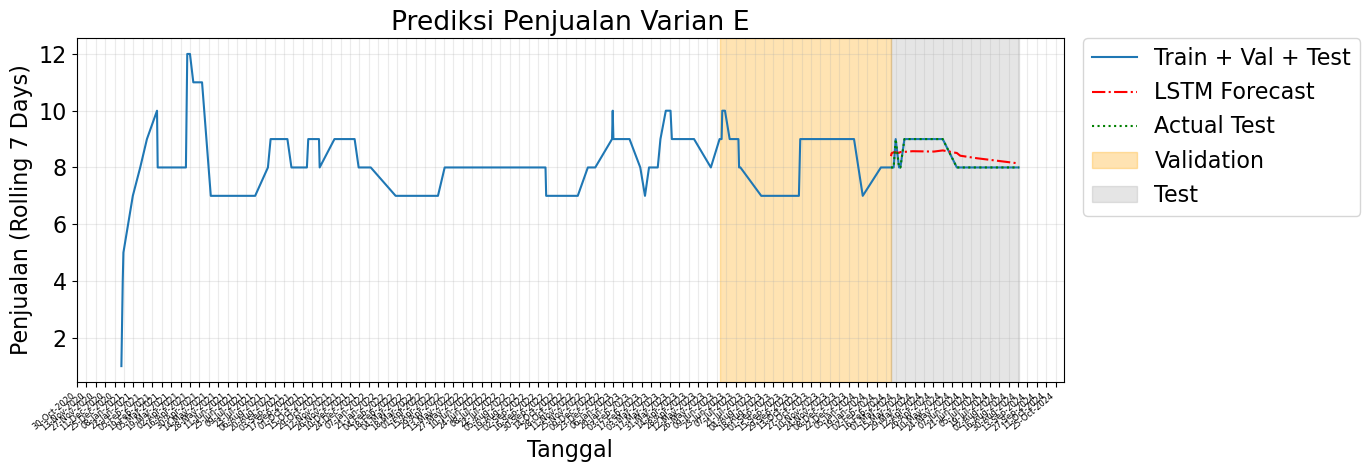

In [34]:
fig, ax = plt.subplots(figsize=(14, 5))

all_dates = pd.concat([train_df, val_df, test_df], ignore_index=True)['Tgl. Mohon']
rolling_values = pd.concat([train_df, val_df, test_df], ignore_index=True)['rolling_7days']

ax.plot(all_dates, rolling_values, label="Train + Val + Test", color="tab:blue")
ax.plot(test_df["Tgl. Mohon"], preds_inverse, "r-.", label="LSTM Forecast")
ax.plot(test_df["Tgl. Mohon"], test_df["rolling_7days"], "g:", label="Actual Test")

formatter = mdates.DateFormatter("%d-%b-%Y")
locator = mdates.DayLocator(interval=14)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Prediksi Penjualan Varian E")
ax.grid("on")

# add forecast area
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], test_df['Tgl. Mohon'].iloc[0], 
           color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df["Tgl. Mohon"].iloc[0], test_df["Tgl. Mohon"].iloc[-1], 
           color="#808080", alpha=0.2, label="Test")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_fontsize(6)
    label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()

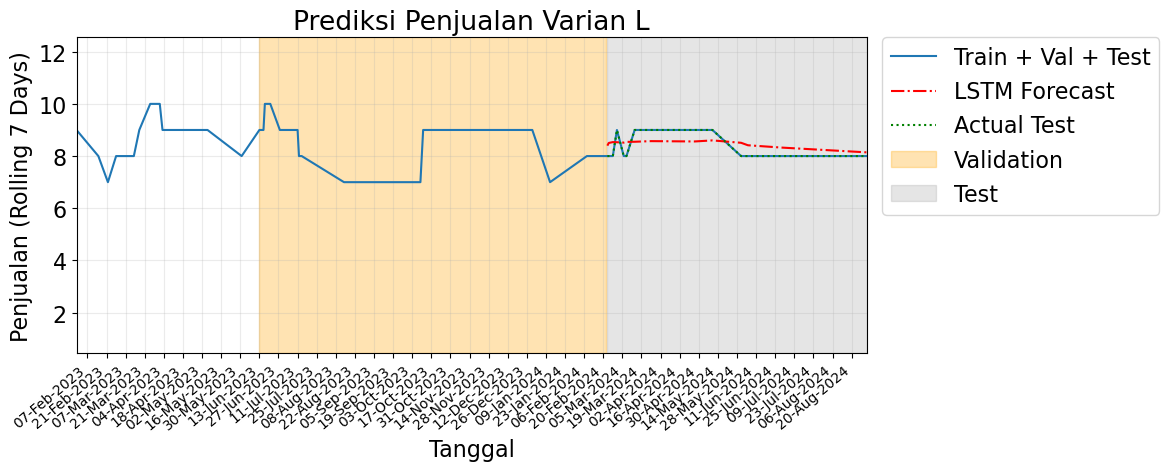

In [35]:
start_idx = 82

xlim = [all_dates.iloc[start_idx], test_df["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(all_dates, rolling_values, label="Train + Val + Test")
ax.plot(test_df["Tgl. Mohon"], preds_inverse, "r-.", label="LSTM Forecast")
ax.plot(test_df["Tgl. Mohon"], test_df["rolling_7days"], "g:", label="Actual Test")

formatter = mdates.DateFormatter("%d-%b-%Y")
locator = mdates.DayLocator(interval=14)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Prediksi Penjualan Varian E")
ax.grid("on")

# Area validation dan test
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
                    color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df["Tgl. Mohon"].iloc[0], test_df["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2, label="Test")

ax.set_xlim(xlim)
ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Prediksi Penjualan Varian L")
ax.grid("on")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_size(10)
    label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.tight_layout()
plt.show()


In [36]:
# --- Ground truth dan prediksi ---
y_true = test_df["rolling_7days"].values
y_pred = preds_inverse[:len(y_true)]  # pastikan sama panjangnya

# --- Evaluasi ---
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# --- MASE (Mean Absolute Scaled Error) ---
# Menggunakan MAE dari naive forecast (persistence model) sebagai pembagi
# Persistence: y_t ≈ y_{t-1}
naive_forecast = y_true[:-1]
actual = y_true[1:]

mae_naive = np.mean(np.abs(actual - naive_forecast))
mase = mae / mae_naive

print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MASE : {mase:.2f}")

MAE  : 0.43
MAPE : 5.21%
MSE  : 0.20
RMSE : 0.45
MASE : 1.41
